<h1 style="
  font-size: 55px;
  text-align: center;
  font-family: 'Poppins', sans-serif;
  text-shadow: 2px 2px 5px rgba(63, 155, 77, 0.84);
  letter-spacing: 2px;
">
  <b>📊 Merged Dataset</b>
</h1>
<hr style="width: 60%; border: 2px solid #21996fd1; border-radius: 5px;">


## <span style="color:#21996fd1;">**6- Model Training & Evaluation**
,---

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, classification_report

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [2]:
df=pd.read_csv("encoded_data.csv")

In [3]:
y = df["TARGET"]
X = df.drop(columns=["TARGET"])
# Use the representative sample created above

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

print("\nTrain distribution:", Counter(y_train))
print("Test distribution :", Counter(y_test))



Train distribution: Counter({0: 211807, 1: 18602})
Test distribution : Counter({0: 70603, 1: 6201})


In [5]:
from sklearn.utils import resample

# دمج X_train + y_train
train_df = X_train.copy()
train_df["TARGET"] = y_train.values

print("Before RUS:", Counter(train_df["TARGET"]))

# فصل majority & minority
df_majority = train_df[train_df["TARGET"] == 0]
df_minority = train_df[train_df["TARGET"] == 1]

df_majority_under = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority) * 2,
    random_state=42
)

train_df = pd.concat([df_majority_under, df_minority]).sample(frac=1, random_state=42)

X_train = train_df.drop("TARGET", axis=1)
y_train = train_df["TARGET"]

print("After RUS:", Counter(y_train))


Before RUS: Counter({0: 211807, 1: 18602})
After RUS: Counter({0: 37204, 1: 18602})


In [6]:
numeric_cols = X_train.select_dtypes(include=["float64", "int64"]).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [7]:
def best_threshold(y_true, y_proba):
    thresholds = np.arange(0.05, 0.90, 0.01)
    best_f1 = 0
    best_t = 0.5

    for t in thresholds:
        preds = (y_proba >= t).astype(int)
        score = f1_score(y_true, preds)
        if score > best_f1:
            best_f1 = score
            best_t = t

    return best_t, best_f1


In [8]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n===================== {name} =====================")
    model.fit(X_train, y_train)

    proba_test = model.predict_proba(X_test)[:, 1]

    # ----------- NEW: find best threshold ----------
    t, f1 = best_threshold(y_test, proba_test)
    print(f"Best threshold: {t:.2f} | Best F1: {f1:.4f}")

    # Predict with best threshold
    pred_test = (proba_test >= t).astype(int)

    print("Test AUC:", roc_auc_score(y_test, proba_test))
    print("Test F1 :", f1_score(y_test, pred_test))
    print("\nClassification Report:")
    print(classification_report(y_test, pred_test))


In [9]:
# from sklearn.model_selection import RandomizedSearchCV
# sample_size = 40000
# X_sample = X_train.sample(sample_size, random_state=42)
# y_sample = y_train.loc[X_sample.index]
#
# rf_params = {
#     "n_estimators": [200, 400, 600, 900],
#     "max_depth": [6, 10, 15, 20, None],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "bootstrap": [True, False]
# }
#
# rf_search = RandomizedSearchCV(
#     RandomForestClassifier(),
#     rf_params,
#     n_iter=25,
#     scoring="f1",
#     cv=3,
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )
#
# rf_search.fit(X_sample, y_sample)
# print(rf_search.best_params_)


In [10]:
# xgb_params = {
#     "n_estimators": [300, 500, 700],
#     "learning_rate": [0.02, 0.04, 0.06],
#     "max_depth": [3, 4, 5, 6],
#     "subsample": [0.7, 0.8, 0.9],
#     "colsample_bytree": [0.6, 0.7, 0.8],
#     "gamma": [0, 1, 5]
# }
#
# xgb_search = RandomizedSearchCV(
#     XGBClassifier(eval_metric="logloss"),
#     xgb_params,
#     cv=3,
#     n_iter=25,
#     n_jobs=-1,
#     scoring="f1",
#     verbose=1,
#     random_state=42
# )
#
# xgb_search.fit(X_sample, y_sample)
# print(xgb_search.best_params_)


In [11]:
# lgb_params = {
#     "num_leaves": [20, 30, 40, 60],
#     "learning_rate": [0.01, 0.02, 0.03, 0.04],
#     "min_child_samples": [20, 50, 100, 150],
#     "feature_fraction": [0.6, 0.7, 0.8, 0.9],
#     "bagging_fraction": [0.6, 0.7, 0.8],
#     "bagging_freq": [3, 5, 10],
#     "reg_alpha": [0, 1, 5],
#     "reg_lambda": [0, 2, 5]
# }
#
# lgb_search = RandomizedSearchCV(
#     lgb.LGBMClassifier(),
#     lgb_params,
#     n_iter=30,
#     scoring="f1",
#     cv=3,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )
#
# lgb_search.fit(X_sample, y_sample)
# print(lgb_search.best_params_)


In [12]:
# cat_params = {
#     "depth": [4, 5, 6, 7, 8],
#     "learning_rate": [0.02, 0.03, 0.04],
#     "l2_leaf_reg": [1, 3, 5, 7, 9],
#     "bagging_temperature": [0.3, 0.5, 1]
# }
#
# cat_search = RandomizedSearchCV(
#     CatBoostClassifier(verbose=False),
#     cat_params,
#     n_iter=20,
#     scoring="f1",
#     cv=3,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )
#
# cat_search.fit(X_sample, y_sample)
# print(cat_search.best_params_)


In [13]:
# models = {
#     "Logistic Regression": LogisticRegression(max_iter=500),
#     "Random Forest": RandomForestClassifier(
#         n_estimators=200,
#         max_depth=None,
#         min_samples_split=2,
#         min_samples_leaf=1,
#         bootstrap=False,
#         random_state=42
#     ),
#     "XGBoost": XGBClassifier(
#         n_estimators=700,
#         learning_rate=0.06,
#         max_depth=4,
#         subsample=0.8,
#         colsample_bytree=0.7,
#         eval_metric="logloss",
#         random_state=42,
#         gamma=0,
#     ),
#     "LightGBM": lgb.LGBMClassifier(
#         n_estimators=400,
#         learning_rate=0.04,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=42
#     ),
#     "CatBoost": CatBoostClassifier(
#         iterations=400,
#         learning_rate=0.04,
#         depth=6,
#         verbose=False,
#         random_state=42
#     )
# }
# for name, model in models.items():
#     evaluate_model(name, model, X_train, y_train, X_test, y_test)
#



Top 40 most important features:

                          feature  importance
3                    EXT_SOURCE_2    0.114316
4                    EXT_SOURCE_3    0.107822
12           ANNUITY_CREDIT_RATIO    0.065850
13           ANNUITY_INCOME_RATIO    0.057463
14            CREDIT_INCOME_RATIO    0.054870
9                  YEARS_EMPLOYED    0.053999
20  APPLICATION_CREDIT_RATIO_MEAN    0.045512
15        CREDIT_GOODS_RATIO_MEAN    0.045067
16         CREDIT_GOODS_RATIO_MAX    0.044715
11             CREDIT_GOODS_RATIO    0.044148
21   APPLICATION_CREDIT_RATIO_MAX    0.042981
23   APPLICATION_CREDIT_RATIO_STD    0.038356
18         CREDIT_GOODS_RATIO_STD    0.037751
10              SOCIAL_CIRCLE_AVG    0.026418
0                 OCCUPATION_TYPE    0.025277
17         CREDIT_GOODS_RATIO_MIN    0.025107
5      AMT_REQ_CREDIT_BUREAU_YEAR    0.023338
2               ORGANIZATION_TYPE    0.022734
22   APPLICATION_CREDIT_RATIO_MIN    0.022332
1                 CNT_FAM_MEMBERS    0.019001


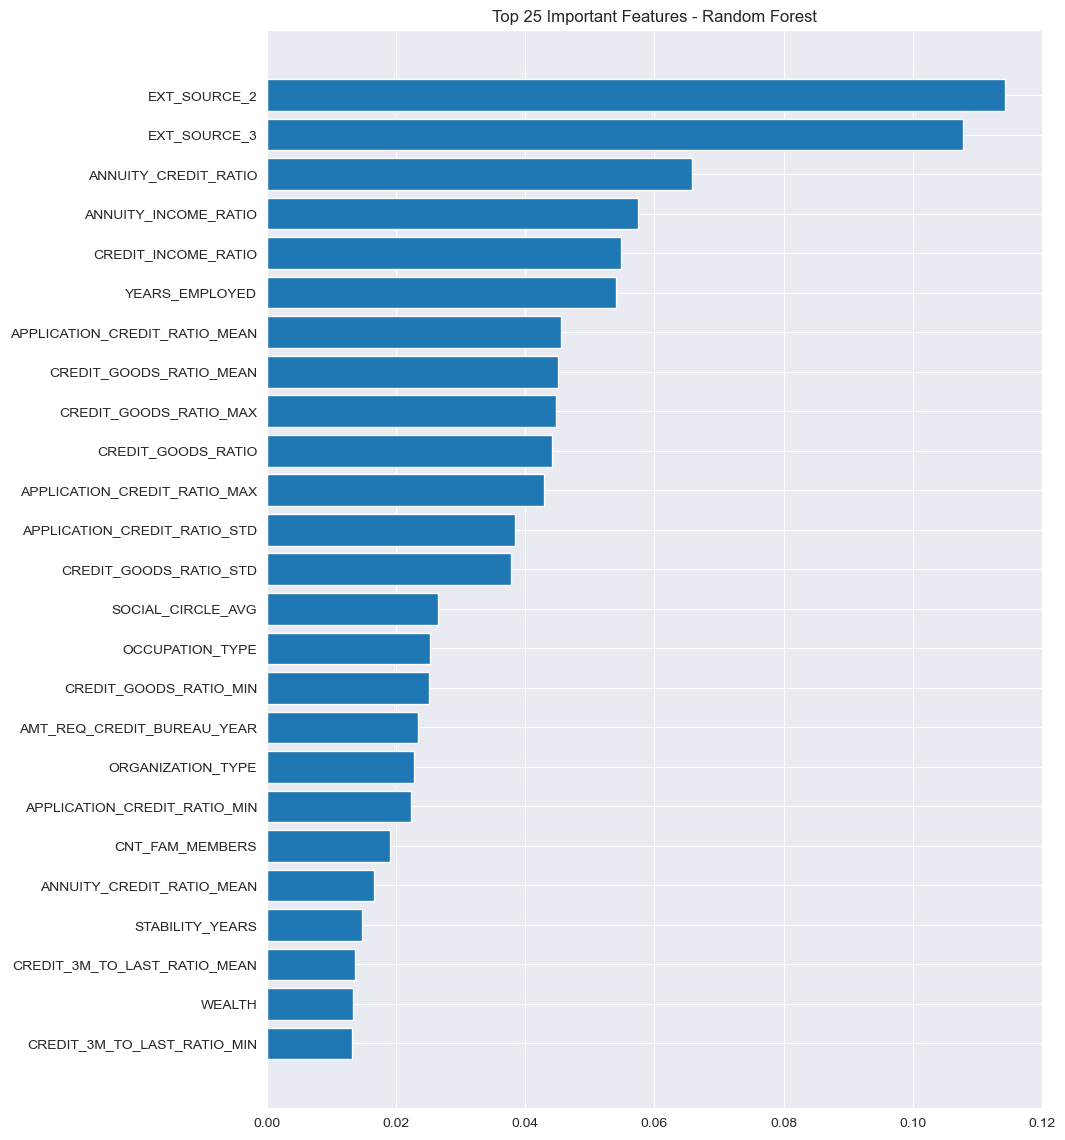

In [14]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# 1) Train Random Forest on balanced training data
# =========================================================

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

# =========================================================
# 2) Extract feature importance
# =========================================================

importances = rf.feature_importances_
feature_names = X_train.columns

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 40 most important features:\n")
print(feat_imp.head(40))

# =========================================================
# 3) Plot Top 25 Features (optional)
# =========================================================

plt.figure(figsize=(10, 14))
plt.barh(feat_imp.head(25)["feature"], feat_imp.head(25)["importance"])
plt.gca().invert_yaxis()
plt.title("Top 25 Important Features - Random Forest")
plt.show()


In [15]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# ===============================
# FOCAL PROBABILITY TRANSFORM
# ===============================
def focal_sigmoid(p, gamma=2.0):
    return p ** gamma   # simulate focal focusing

# ===============================
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.006,
    'num_leaves': 31,
    'max_depth': 7,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 200,
    'min_split_gain': 0.01,
    'reg_alpha': 5.0,
    'reg_lambda': 10.0,
    'class_weight': 'balanced',
    'subsample_for_bin': 200000,
}



model = lgb.LGBMClassifier(
    **params,
    n_estimators=3000
)

# ===============================
# FIT
# ===============================
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)


# ===============================
# PREDICT WITH FOCAL
# ===============================
raw_pred = model.predict_proba(X_test)[:, 1]
focal_pred = focal_sigmoid(raw_pred)

best_f1, best_thr = 0, 0
for thr in np.linspace(0.1, 0.6, 50):
    pred = (focal_pred >= thr).astype(int)
    f1 = f1_score(y_test, pred)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print(f"\nBest threshold: {best_thr:.4f}")
print(f"Best F1: {best_f1:.4f}")

final_pred = (focal_pred >= best_thr).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, final_pred))

print("AUC:", roc_auc_score(y_test, focal_pred))

# ===============================
raw_pred_train = model.predict_proba(X_train)[:, 1]
focal_pred_train = focal_sigmoid(raw_pred_train)

train_pred = (focal_pred_train >= best_thr).astype(int)

print("\n=========== TRAIN REPORT ===========")
print(classification_report(y_train, train_pred))
print("Train AUC:", roc_auc_score(y_train, focal_pred_train))

C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 18602, number of negative: 37204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4698
[LightGBM] [Info] Number of dat

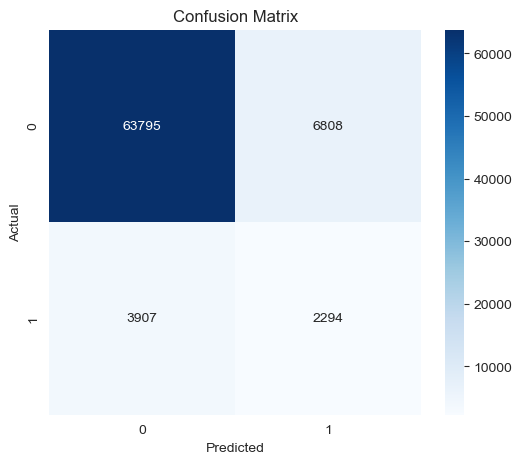

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# حساب الـ confusion matrix
cm = confusion_matrix(y_test, final_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
import lightgbm as lgb


def focal_sigmoid(p, gamma=3.0):
    return p ** gamma


params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.006,
    'num_leaves': 31,
    'max_depth': 7,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 200,
    'min_split_gain': 0.01,
    'reg_alpha': 5.0,
    'reg_lambda': 10.0,
    'class_weight': 'balanced',
    'subsample_for_bin': 200000,
    'metric': 'binary_logloss'
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_auc = []
fold_f1 = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):

    print(f"\n==================== Fold {fold+1} ====================")

    X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]

    model = lgb.LGBMClassifier(
        **params,
        n_estimators=3000
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=100)]
    )

    raw = model.predict_proba(X_val)[:, 1]
    focal = focal_sigmoid(raw)

    # find best threshold per fold
    best_f1, best_thr = 0, 0
    for thr in np.linspace(0.05, 0.5, 80):
        pred = (focal >= thr).astype(int)
        f1 = f1_score(y_val, pred)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr

    fold_auc.append(roc_auc_score(y_val, focal))
    fold_f1.append(best_f1)

    print(f"Fold AUC: {fold_auc[-1]:.4f}")
    print(f"Fold F1 : {best_f1:.4f} @ thr={best_thr:.4f}")


print("\n==================== FINAL CV RESULT ====================")
print(f"Mean AUC: {np.mean(fold_auc):.4f}  |  Std: {np.std(fold_auc):.4f}")
print(f"Mean F1 : {np.mean(fold_f1):.4f}  |  Std: {np.std(fold_f1):.4f}")


==================== Fold 1 ====================
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 19842, number of negative: 225928
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [In

In [18]:
# # =====================================================
# # 1) IMPORTS
# # =====================================================
# import tensorflow as tf
# from tensorflow.keras import layers, models, callbacks
# from tensorflow.keras import backend as K   # <-- IMPORTANT FIX
# from sklearn.metrics import roc_auc_score, f1_score, classification_report
#
#
# # =====================================================
# # 2) FOCAL LOSS FUNCTION (Correct Version)
# # =====================================================
# def focal_loss(gamma=2., alpha=0.25):
#     def loss(y_true, y_pred):
#         y_true = K.cast(y_true, dtype='float32')
#         y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())  # numerical stability
#
#         cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
#
#         weight = alpha * K.pow((1 - y_pred), gamma)
#         return K.mean(weight * cross_entropy)
#     return loss
#
#
# # =====================================================
# # 3) BUILD THE MODEL
# # =====================================================
# model = models.Sequential([
#     layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#
#     layers.Dense(64, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),
#
#     layers.Dense(32, activation='relu'),
#     layers.Dropout(0.1),
#
#     layers.Dense(1, activation='sigmoid')
# ])
#
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss=focal_loss(gamma=2, alpha=0.25),
#     metrics=['AUC']
# )
#
#
# # =====================================================
# # 4) TRAIN WITH EARLY STOPPING
# # =====================================================
# es = callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=7,
#     restore_best_weights=True
# )
#
# history = model.fit(
#     X_train, y_train,
#     validation_split=0.15,
#     epochs=25,
#     batch_size=512,
#     callbacks=[es],
#     verbose=1
# )
#
#
# # =====================================================
# # 5) EVALUATE
# # =====================================================
# y_train_proba = model.predict(X_train).ravel()
# y_test_proba = model.predict(X_test).ravel()
#
# y_train_pred = (y_train_proba > 0.5).astype(int)
# y_test_pred = (y_test_proba > 0.5).astype(int)
#
# print("\n================ NEURAL NETWORK WITH FOCAL LOSS ================")
# print("Train AUC:", roc_auc_score(y_train, y_train_proba))
# print("Test AUC:", roc_auc_score(y_test, y_test_proba))
# print("Train F1:", f1_score(y_train, y_train_pred))
# print("Test F1:", f1_score(y_test, y_test_pred))
# print("\nClassification Report:")
# print(classification_report(y_test, y_test_pred))

In [19]:
df.head()

,TARGET,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_YEAR,PHONE_CHANGE_STATUS,WEALTH,STABILITY_YEARS,...,CREDIT_GOODS_RATIO_MAX,CREDIT_GOODS_RATIO_MIN,CREDIT_GOODS_RATIO_STD,ANNUITY_CREDIT_RATIO_MEAN,APPLICATION_CREDIT_RATIO_MEAN,APPLICATION_CREDIT_RATIO_MAX,APPLICATION_CREDIT_RATIO_MIN,APPLICATION_CREDIT_RATIO_STD,CREDIT_3M_TO_LAST_RATIO_MEAN,CREDIT_3M_TO_LAST_RATIO_MIN
0,1,1,1.0,0,0.262949,0.139376,1.0,0,2,2,...,1.000000,1.000000,0.000000,5.167002e-02,1.000000,1.000000,1.000000,0.000000,1.000000e+00,1.000000
1,0,0,2.0,1,0.622246,0.546023,0.0,0,1,2,...,1.150980,0.989013,0.083753,1.263834e-01,0.949329,1.011109,0.868825,0.072967,1.328538e+00,1.000000
2,0,1,1.0,3,0.555912,0.729567,0.0,0,0,2,...,0.828021,0.828021,0.000000,2.664503e-01,1.207699,1.207699,1.207699,0.000000,1.000000e+00,1.000000
3,0,1,2.0,0,0.650442,0.560284,2.0,0,2,0,...,1.316797,0.000000,0.491534,4.688077e+12,0.758072,1.250017,0.000000,0.488096,7.171875e+13,0.408468
4,0,0,1.0,5,0.322738,0.562060,0.0,0,2,2,...,1.264000,0.850930,0.137998,9.065882e-02,0.969650,1.175185,0.791139,0.128282,9.694093e-01,0.816456


# rus

In [37]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.utils import resample
from collections import Counter

# =========================================
# 1) SELECT TOP FEATURES
# =========================================
top_17_features = [
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "ANNUITY_CREDIT_RATIO",
    "ANNUITY_INCOME_RATIO",
    "CREDIT_INCOME_RATIO",
    "YEARS_EMPLOYED",
    "APPLICATION_CREDIT_RATIO_MEAN",
    "APPLICATION_CREDIT_RATIO_MAX",
    "APPLICATION_CREDIT_RATIO_STD",
    "CREDIT_GOODS_RATIO_MEAN",
    "CREDIT_GOODS_RATIO_MAX",
    "CREDIT_GOODS_RATIO_STD",
    "APPLICATION_CREDIT_RATIO_MIN",
    "CREDIT_GOODS_RATIO_MIN",
    "SOCIAL_CIRCLE_AVG",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
    "CREDIT_3M_TO_LAST_RATIO_MEAN"
]
df = df[top_17_features + ["TARGET"]]
raw_pred = model.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [38]:
X = df[top_17_features]
y = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [22]:
# train_df = X_train.copy()
# train_df["TARGET"] = y_train.values
#
# df_majority = train_df[train_df["TARGET"] == 0]
# df_minority = train_df[train_df["TARGET"] == 1]
#
# df_majority_under = resample(
#     df_majority,
#     replace=False,
#     n_samples=len(df_minority) * 2,   # ratio = 2:1
#     random_state=42
# )
#
# df_train_rus = pd.concat(
#     [df_majority_under, df_minority]
# ).sample(frac=1, random_state=42)
#
# # overwrite train
# X_train = df_train_rus.drop("TARGET", axis=1)
# y_train = df_train_rus["TARGET"]
#
# print("\nAfter RUS:", Counter(y_train))
# print("Test remains:", Counter(y_test))

In [23]:
# from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, classification_report, confusion_matrix
# import optuna
#
# def objective(trial):
#     param = {
#         "boosting_type": "gbdt",
#         "objective": "binary",
#         "metric": "binary_logloss",
#         "verbosity": -1,
#         "n_jobs": -1,
#         "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 32, 128),
#         "min_child_samples": trial.suggest_int("min_child_samples", 20, 120),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": 5,
#         "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
#         "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
#         "max_depth": trial.suggest_categorical("max_depth", [-1, 6, 8, 12])
#     }
#
#     # 3-fold stratified CV on the RUS train
#     skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#     scores = []
#     for tr_idx, val_idx in skf.split(X_train, y_train):
#         X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
#         y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
#
#         clf = lgb.LGBMClassifier(**param, n_estimators=5000)
#         # use callbacks for early stopping to avoid TypeError
#         clf.fit(
#             X_tr, y_tr,
#             eval_set=[(X_val, y_val)],
#             callbacks=[
#                 lgb.early_stopping(stopping_rounds=100),
#                 lgb.log_evaluation(period=0)
#             ]
#         )
#
#         proba = clf.predict_proba(X_val)[:, 1]
#         scores.append(average_precision_score(y_val, proba))
#
#     return float(np.mean(scores))
#
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=60, show_progress_bar=True)
#
# print("Best Optuna params:")
# print(study.best_params)

In [24]:
# best_params = study.best_params
# # add fixed params
# best_params.update({
#     "boosting_type": "gbdt",
#     "objective": "binary",
#     "n_jobs": -1
# })
#
# X_tr, X_val, y_tr, y_val = train_test_split(
#     X_train, y_train, test_size=0.20, stratify=y_train, random_state=42
# )
#
# final_clf = lgb.LGBMClassifier(**best_params, n_estimators=8000)
#
# final_clf.fit(
#     X_tr, y_tr,
#     eval_set=[(X_val, y_val)],
#     callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(period=0)]
# )


In [25]:
# # -------------------------
# # 5) Threshold tuning on validation
# # -------------------------
# val_proba = final_clf.predict_proba(X_val)[:, 1]
# best_f1, best_thr = 0.0, 0.5
# for t in np.linspace(0.05, 0.95, 91):
#     preds = (val_proba >= t).astype(int)
#     # f1 = f1_score(y_val, preds)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_thr = t
#
# print("Validation best F1:", best_f1, "best threshold:", best_thr)

In [26]:
# test_proba = final_clf.predict_proba(X_test)[:, 1]
# test_pred = (test_proba >= best_thr).astype(int)
#
# print("\n=== TEST RESULTS ===")
# print("AUC (ROC):", roc_auc_score(y_test, test_proba))
# print("PR-AUC:", average_precision_score(y_test, test_proba))
# print("F1:", f1_score(y_test, test_pred))
# print(classification_report(y_test, test_pred))
# print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))

In [27]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score, roc_auc_score, classification_report, average_precision_score
# from sklearn.utils import resample
# from collections import Counter
# import lightgbm as lgb
# import optuna
# import warnings
# warnings.filterwarnings("ignore")
#
# # ======================================================
# # 1 — PREPARE DATA
# # ======================================================
# top_17_features = [
#     "EXT_SOURCE_2","EXT_SOURCE_3","ANNUITY_CREDIT_RATIO","ANNUITY_INCOME_RATIO",
#     "CREDIT_INCOME_RATIO","YEARS_EMPLOYED","APPLICATION_CREDIT_RATIO_MEAN",
#     "APPLICATION_CREDIT_RATIO_MAX","APPLICATION_CREDIT_RATIO_STD","CREDIT_GOODS_RATIO_MEAN",
#     "CREDIT_GOODS_RATIO_MAX","CREDIT_GOODS_RATIO_STD","APPLICATION_CREDIT_RATIO_MIN",
#     "CREDIT_GOODS_RATIO_MIN","SOCIAL_CIRCLE_AVG","AMT_REQ_CREDIT_BUREAU_YEAR",
#     "CREDIT_3M_TO_LAST_RATIO_MEAN"
# ]
#
# df = df[top_17_features + ["TARGET"]].reset_index(drop=True)
# X = df[top_17_features]
# y = df["TARGET"]
#
# # Train/Test Split
# X_train_full, X_test, y_train_full, y_test = train_test_split(
#     X, y, test_size=0.25, stratify=y, random_state=42
# )
#
# print("Train dist:", Counter(y_train_full))
# print("Test dist :", Counter(y_test))
#
#
# # ======================================================
# # 2 — OPTUNA TO TUNE LIGHTGBM (only once)
# # ======================================================
#
# def objective(trial):
#     params = {
#         "boosting_type": "gbdt",
#         "objective": "binary",
#         "metric": "binary_logloss",
#         "verbosity": -1,
#         "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.03, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 32, 128),
#         "min_child_samples": trial.suggest_int("min_child_samples", 20, 120),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
#         "bagging_freq": 5,
#         "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 3.0),
#         "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0)
#     }
#
#     # simple validation to rank hyperparams
#     X_tr, X_val, y_tr, y_val = train_test_split(
#         X_train_full, y_train_full,
#         test_size=0.20, stratify=y_train_full, random_state=42
#     )
#
#     clf = lgb.LGBMClassifier(**params, n_estimators=3000)
#     clf.fit(
#         X_tr, y_tr,
#         eval_set=[(X_val, y_val)],
#         callbacks=[lgb.early_stopping(200)]
#     )
#
#     proba = clf.predict_proba(X_val)[:, 1]
#     return average_precision_score(y_val, proba)
#
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)
#
# best_params = study.best_params
# best_params["objective"] = "binary"
# best_params["boosting_type"] = "gbdt"
#
# print("Best params:", best_params)
#
#
# # ======================================================
# # 3 — BUILD ENSEMBLE OF 5 RUS MODELS
# # ======================================================
#
# def train_single_rus_model(seed):
#     # create a new RUS sample each time
#     train_df = X_train_full.copy()
#     train_df["TARGET"] = y_train_full.values
#
#     df_majority = train_df[train_df["TARGET"] == 0]
#     df_minority = train_df[train_df["TARGET"] == 1]
#
#     # RUS ratio = 2 (best for ensemble)
#     df_majority_under = resample(
#         df_majority,
#         replace=False,
#         n_samples=len(df_minority) * 2,
#         random_state=seed
#     )
#
#     df_rus = pd.concat([df_majority_under, df_minority]).sample(frac=1, random_state=seed)
#     X_rus = df_rus.drop("TARGET", axis=1)
#     y_rus = df_rus["TARGET"]
#
#     clf = lgb.LGBMClassifier(**best_params, n_estimators=5000)
#
#     clf.fit(
#         X_rus, y_rus,
#         callbacks=[lgb.log_evaluation(period=0)]
#     )
#
#     return clf
#
#
# # Train 5 models
# models = []
# for i in range(5):
#     print(f"Training model #{i+1}")
#     models.append(train_single_rus_model(seed=100+i))
#
#
# # ======================================================
# # 4 — AVERAGE PREDICTIONS (ENSEMBLE)
# # ======================================================
# test_probas = np.zeros(len(X_test))
#
# for m in models:
#     test_probas += m.predict_proba(X_test)[:, 1]
#
# test_probas /= len(models)
#
#
# # ======================================================
# # 5 — THRESHOLD TUNING ON VALIDATION
# # ======================================================
# # build a validation split from train_FULL
# X_tr, X_val, y_tr, y_val = train_test_split(
#     X_train_full, y_train_full,
#     test_size=0.20, stratify=y_train_full, random_state=42
# )
#
# # ensemble probas for validation too:
# val_probas = np.zeros(len(X_val))
# for m in models:
#     val_probas += m.predict_proba(X_val)[:, 1]
# val_probas /= len(models)
#
# best_f1, best_thr = 0, 0
# for t in np.linspace(0.05, 0.45, 80):
#     preds = (val_probas >= t).astype(int)
#     f1 = f1_score(y_val, preds)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_thr = t
#
# print("Best threshold:", best_thr)
# print("Best val F1:", best_f1)
#
#
# # ======================================================
# # 6 — FINAL EVALUATION
# # ======================================================
# test_pred = (test_probas >= best_thr).astype(int)
#
# print("\n=== FINAL TEST RESULTS ===")
# print("AUC:", roc_auc_score(y_test, test_probas))
# print("PR-AUC:", average_precision_score(y_test, test_probas))
# print("F1:", f1_score(y_test, test_pred))
# print(classification_report(y_test, test_pred))


In [28]:
# import pickle
#
# with open("models/credit_model.pkl", "wb") as f:
#     pickle.dump(model, f)
# print("\nModel saved successfully as credit_model.pkl")

In [39]:
for col in df.columns:
  print(col.upper())
  print(df[col].unique())
  print("\n--------------------------------------")

EXT_SOURCE_2
[0.26294859 0.62224578 0.55591208 ... 0.13118876 0.26448565 0.2678342 ]

--------------------------------------
EXT_SOURCE_3
[1.39375780e-01 5.46023197e-01 7.29566691e-01 5.60284328e-01
 5.62060483e-01 6.21226338e-01 4.92060094e-01 5.40654450e-01
 7.51723715e-01 5.13693766e-01 3.63945239e-01 6.52896552e-01
 1.76652579e-01 7.70087070e-01 5.33481630e-01 6.78567689e-01
 6.21030378e-02 4.43615308e-01 5.56727426e-01 4.77649155e-01
 5.83237926e-01 5.42445144e-01 3.58951229e-01 6.69056695e-01
 5.65607981e-01 4.61482391e-01 1.90705948e-01 6.59405532e-01
 5.24496446e-01 4.68659655e-01 4.10102573e-01 4.88455184e-01
 7.98137231e-01 4.11848556e-01 7.54406173e-01 7.22392890e-01
 6.05836265e-01 3.20163367e-01 5.26294940e-01 3.99675616e-01
 6.84827659e-01 4.45396242e-01 3.03146374e-01 4.75849909e-01
 7.28141299e-01 4.66864006e-01 4.79448981e-01 3.09275356e-01
 7.99296783e-01 7.01695774e-01 7.38019620e-01 7.01088438e-02
 1.69428727e-01 7.07699345e-01 3.39287700e-01 6.97146908e-01
 4.34733

In [40]:
print(X_train.columns.tolist())


['EXT_SOURCE_2', 'EXT_SOURCE_3', 'ANNUITY_CREDIT_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_INCOME_RATIO', 'YEARS_EMPLOYED', 'APPLICATION_CREDIT_RATIO_MEAN', 'APPLICATION_CREDIT_RATIO_MAX', 'APPLICATION_CREDIT_RATIO_STD', 'CREDIT_GOODS_RATIO_MEAN', 'CREDIT_GOODS_RATIO_MAX', 'CREDIT_GOODS_RATIO_STD', 'APPLICATION_CREDIT_RATIO_MIN', 'CREDIT_GOODS_RATIO_MIN', 'SOCIAL_CIRCLE_AVG', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CREDIT_3M_TO_LAST_RATIO_MEAN']


In [41]:
df['TARGET'].value_counts(normalize=True)

TARGET
0    0.919264
1    0.080736
Name: proportion, dtype: float64

In [32]:
df.drop(columns=["TARGET"]).head(30).to_csv("sample_head.csv", index=False)


In [42]:
df.head(30)

,EXT_SOURCE_2,EXT_SOURCE_3,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,CREDIT_INCOME_RATIO,YEARS_EMPLOYED,APPLICATION_CREDIT_RATIO_MEAN,APPLICATION_CREDIT_RATIO_MAX,APPLICATION_CREDIT_RATIO_STD,CREDIT_GOODS_RATIO_MEAN,CREDIT_GOODS_RATIO_MAX,CREDIT_GOODS_RATIO_STD,APPLICATION_CREDIT_RATIO_MIN,CREDIT_GOODS_RATIO_MIN,SOCIAL_CIRCLE_AVG,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_3M_TO_LAST_RATIO_MEAN,TARGET
0,0.262949,0.139376,0.060749,0.121978,2.007889,1.7,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.00,1.0,1.000000e+00,1
1,0.622246,0.546023,0.027598,0.132217,4.790750,3.3,0.949329,1.011109,0.072967,1.057664,1.150980,0.083753,0.868825,0.989013,0.50,0.0,1.328538e+00,0
2,0.555912,0.729567,0.050000,0.100000,2.000000,0.6,1.207699,1.207699,0.000000,0.828021,0.828021,0.000000,1.207699,0.828021,0.00,0.0,1.000000e+00,0
3,0.650442,0.560284,0.094941,0.219900,2.316167,8.3,0.758072,1.250017,0.488096,0.759513,1.316797,0.491534,0.000000,0.000000,1.00,2.0,7.171875e+13,0
4,0.322738,0.562060,0.042623,0.179963,4.222222,8.3,0.969650,1.175185,0.128282,1.046356,1.264000,0.137998,0.791139,0.850930,0.00,0.0,9.694093e-01,0
5,0.354225,0.621226,0.056101,0.277955,4.954500,4.4,0.824039,1.112625,0.469292,0.782855,1.115500,0.446606,0.000000,0.000000,0.00,1.0,8.000000e-01,0
6,0.724000,0.492060,0.026463,0.241526,9.127053,8.6,1.095482,1.191067,0.072435,0.916226,1.000000,0.059823,1.000000,0.839583,0.50,2.0,1.014456e+00,0
7,0.714279,0.540654,0.027500,0.116875,4.250000,1.2,0.947859,0.947859,0.000000,1.055009,1.055009,0.000000,0.947859,1.055009,1.00,0.0,1.000000e+00,0
8,0.205747,0.751724,0.033176,0.300680,9.063200,0.0,0.483006,1.011045,0.558938,0.852052,1.333333,0.586242,0.000000,0.000000,0.50,1.0,6.250000e-01,0
9,0.746644,0.513694,0.050000,0.150000,3.000000,5.5,0.607313,0.851692,0.405961,0.927425,1.269700,0.619859,0.000000,0.000000,1.00,2.0,7.500000e-01,0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307213 entries, 0 to 307212
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   EXT_SOURCE_2                   307213 non-null  float64
 1   EXT_SOURCE_3                   307213 non-null  float64
 2   ANNUITY_CREDIT_RATIO           307213 non-null  float64
 3   ANNUITY_INCOME_RATIO           307213 non-null  float64
 4   CREDIT_INCOME_RATIO            307213 non-null  float64
 5   YEARS_EMPLOYED                 307213 non-null  float64
 6   APPLICATION_CREDIT_RATIO_MEAN  307213 non-null  float64
 7   APPLICATION_CREDIT_RATIO_MAX   307213 non-null  float64
 8   APPLICATION_CREDIT_RATIO_STD   307213 non-null  float64
 9   CREDIT_GOODS_RATIO_MEAN        307213 non-null  float64
 10  CREDIT_GOODS_RATIO_MAX         307213 non-null  float64
 11  CREDIT_GOODS_RATIO_STD         307213 non-null  float64
 12  APPLICATION_CREDIT_RATIO_MIN  

# unsupervised

In [ ]:
import optuna
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

X = df.drop(columns=['TARGET'])
y = df['TARGET']

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# objective function
def objective(trial):
    contamination = trial.suggest_float("contamination", 0.01, 0.30)

    model = IsolationForest(
        contamination=contamination,
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(X_train)

    # Prediction: -1 anomaly → 1 fraud
    preds = model.predict(X_test)
    preds = [1 if p == -1 else 0 for p in preds]

    # Score of this trial
    auc = roc_auc_score(y_test, preds)

    # optional: اطبع نتيجة كل تجربة
    print(f"Trial: contamination={contamination:.4f} → AUC={auc:.4f}")

    return auc  # بنرجّع الـ score ده لـ Optuna

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

# === FINAL RESULTS ===
print("\n===== BEST RESULT =====")
print("Best contamination:", study.best_params["contamination"])
print("Best AUC Score:", study.best_value)


[I 2025-11-29 00:05:05,113] A new study created in memory with name: no-name-d331ad8a-5e8c-4e28-91ad-9d5d82cf4d98
